# CASES 03
# Complex Adaptive Socio-Economic Systems

*We are trying to understand risks, not predict the future*

## Exploration
How did the COVID-19 pandemic set economic decline in motion, and what does the future look like? The pandemic has two obvious economic impacts: direct responses to infection in terms of mortality and lost workers, and decisions made to combat spread of the virus, most notably interruptions of human movement and interaction (shelter in place, shutdown, lockdown, etc.). The result of the impacts are likely to be complex for two reasons. First, the socio-economic network is a complex one, with multiple propagating effects and feedbacks of any adjustment of the system. Second, the impacts are heterogeneous. For example, the demographic biases of the virus, such as age and racial biases, suggest that industrial sectors would be imapcted differently by the disease. Furthermore, political and social decisions made as a result of the pandemic have had and will have variable effects on different sectors, e.g. the severe consequences of shuttering hotels and restaurants, while protecting health care services.

While the overall complexity of the system can be explored with high level analyses of system-wide shocks and comparative analyses between different SESs, the details of what might be happening with any particular SES, and forecasts for individual SESs, require a more microscopic understanding. There is a huge number of degrees of freedom in these systems. There is no way in which to conduct exhaustive explorations of all possible impacts and outcomes, but "experiments" can be conducted to gain insight into what might be influencing the results of high level analyses.

The following notebook is the first attempt to build a little machine with which we can conduct those sorts of experiments. It will become most useful when applying detailed empirical data, and generating possible forecasts.

## The network
The CASES (Complex Adaptive Socio-Economic Systems) model constructs SESs as networks of interacting socio-economic or socio-ecological sectors. Each sector is a network node, and inter-industry economic exchanges are sector interactions. Two data determine the structure of a network. First are sector sizes, i.e. the number of employees per sector. Second are the interaction strengths between sectors. These are asymmetric interactions, being the magnitude of financial benefit that sector $i$ derives from sector $j$, and *visa versa*. Thus the relationships are mutualistic, and an interaction at any given time is given as
$$
I_{ij}(t) = \frac{\beta_{ij}E_j(t)}{E_{j,0}}
$$
where $\beta_ij$ is the proportion of $i$'s total benefits that are derived from $j$. $E_j(t)$ is the size, or number of employees in $j$, and $E_{j,0}$ is the initial size of the sector. Note that the sum of all a sector's $\beta$ coefficients is 1. 

Based on the 2018 inter-industry statistics from the US Bureau of Labor Statistics, the average interdependencies among the standard 15 major sectors are

In [1]:
using DifferentialEquations, Plots, DelimitedFiles, CSV

In [7]:
# reading a delimited file
reqs = readdlm("US_exchanges_2018.csv");

The row normalized transformation is the $\mathbf{B}$ matrix, where $\beta_{ij}$ the $ij^\text{th}$ element.

In [231]:
# transpose the USBLS array
I = reqs'
# sum the rows
sum_I = sum(I, dims=2)
# normalize elements in row according to row sums
# therefore total support for each sector sums to 1
no_sectors = size(I,1)
B = Array{Float64}(undef,no_sectors,no_sectors)
for i = 1:no_sectors
    for j = 1:no_sectors
        B[i,j] = I[i,j]/sum_I[i]
    end
end
#uncomment the next line to see the matrix
#print(B)

The number of workers employed per sector in the Los Angeles Metropolitan Area is

In [228]:
# reading a dataframe
LA_employed = CSV.read("LA_employment_by_sector_03_20.csv")

,Sector,Employed
,String,Int64
1,Total farm,4200
2,Mining and logging,1900
3,Construction,148900
4,Manufacturing,328900
5,Wholesale trade,217000
6,Retail trade,413800
7,"Transportation, warehousing and utilities",203700
8,Information,234300
9,Financial,227000


## Network dynamics
Network dynamics are described by the growth of the sector employment
$$
\begin{align}
& \frac{dE_i}{dt} = E_i\left ( \sum_{j=1}^{S}\frac{\beta_{ij}E_j}{E_{j,0}} - 1 \right ) - \lambda E_i - \delta E_i + \rho U_i \\
& \Rightarrow E_i\left [ \sum_{j=1}^S \frac{\beta_{ij}E_j}{E_{j,0}} - (1+\lambda_k+\delta)\right ] + \rho U_i \\
& \frac{dU_i}{dt} = E_i\left [ (1+\lambda_k) - \sum_{j=1}^S \frac{\beta_{ij}E_j}{E_{j,0}}\right ] - U_i(\rho + \delta)
\end{align}
$$
where $E_i$ is employment in sector $i$, $U_i$ is unemployment for that sector, and $\lambda$ is the rate at which workers are laid off, $\delta$ is a pandemic mortality rate, and $\rho$ is the rate at which unemployed workers are re-hired. The system is in static equilibrium if sector sizes remain constant. The growth (negative or positive) of any sector will result in a non-zero growth rate of sector $i$, as the summed term falls below, or exceeds 1.

We demonstrate this with a sub-network of the above example, consisting of the "Manufacturing", "Transportation and utilities", "Education and health services" and "Leisure and hospitality" sectors. Our subset of the $\mathbf{B}$ matrix is therefore

In [232]:
# each example sector
a = B[5,:]
b = B[8,:]
c = B[12,:]
d = B[13,:]

# interaction sub-matrix
I2 = [a[5] a[8] a[12] a[13];b[5] b[8] b[12] b[13];c[5] c[8] c[12] c[13];d[5] d[8] d[12] d[13]]

# re-normalize
sum_I2 = sum(I2, dims=2)
no_sectors = size(I2,1)
B2 = Array{Float64}(undef,no_sectors,no_sectors)
for i = 1:no_sectors
    for j = 1:no_sectors
        B2[i,j] = I2[i,j]/sum_I2[i]
    end
end
#uncomment the next line to see the matrix
print(B2)

[0.0 0.880051 0.0061026 0.113846; 0.88631 0.0 0.00417419 0.109516; 0.737582 0.121445 0.0 0.140972; 0.848655 0.142079 0.00926668 0.0]

and sector sizes are

In [233]:
n = [328900.0, 203700.0, 858300.0, 517800.0]

4-element Array{Float64,1}:
 328900.0
 203700.0
 858300.0
 517800.0

We now write our system of differential equations, as given above. This is the most difficult section, as each equation is unique, and care has to be taken to use the correct indices. Furthermore, the parameters are now represented as a matrix, as each sector is permitted to have unique values for the parameters.

In [159]:
function sector1!(du,u,p,t)
    l,d,r = p
    
    du[1] = u[1]*(round((B2[1,1]*u[1]/u0[1])+(B2[1,2]*u[2]/u0[2])+(B2[1,3]*u[3]/u0[3])+(B2[1,4]*u[4]/u0[4])) - (1.0+p[1,1]+p[2,1])) + (p[3,1]*u[5])
    du[2] = u[2]*(round((B2[2,1]*u[1]/u0[1])+(B2[2,2]*u[2]/u0[2])+(B2[2,3]*u[3]/u0[3])+(B2[2,4]*u[4]/u0[4])) - (1.0+p[1,2]+p[2,2])) + (p[3,2]*u[6])
    du[3] = u[3]*(round((B2[3,1]*u[1]/u0[1])+(B2[3,2]*u[2]/u0[2])+(B2[3,3]*u[3]/u0[3])+(B2[3,4]*u[4]/u0[4])) - (1.0+p[1,3]+p[2,3])) + (p[3,3]*u[7])
    du[4] = u[4]*(round((B2[4,1]*u[1]/u0[1])+(B2[4,2]*u[2]/u0[2])+(B2[4,3]*u[3]/u0[3])+(B2[4,4]*u[4]/u0[4])) - (1.0+p[1,4]+p[2,4])) + (p[3,4]*u[8])
    du[5] = (u[1]*((1.0+p[1,1]) - round((B2[1,1]*u[1]/u0[1])+(B2[1,2]*u[2]/u0[2])+(B2[1,3]*u[3]/u0[3])+(B2[1,4]*u[4]/u0[4])))) - (u[5]*(p[2,1]+p[3,1]))
    du[6] = (u[2]*((1.0+p[1,2]) - round((B2[2,1]*u[1]/u0[1])+(B2[2,2]*u[2]/u0[2])+(B2[2,3]*u[3]/u0[3])+(B2[2,4]*u[4]/u0[4])))) - (u[6]*(p[2,2]+p[3,2]))
    du[7] = (u[3]*((1.0+p[1,3]) - round((B2[3,1]*u[1]/u0[1])+(B2[3,2]*u[2]/u0[2])+(B2[3,3]*u[3]/u0[3])+(B2[3,4]*u[4]/u0[4])))) - (u[7]*(p[2,3]+p[3,3]))
    du[8] = (u[4]*((1.0+p[1,4]) - round((B2[4,1]*u[1]/u0[1])+(B2[4,2]*u[2]/u0[2])+(B2[4,3]*u[3]/u0[3])+(B2[4,4]*u[4]/u0[4])))) - (u[8]*(p[2,4]+p[3,4]))
end

sector1! (generic function with 1 method)

In [234]:
# the initial values, or initial sector sizes
u0 = Float64[328900.00,203700.00,858300.00,517800.00,0.00,0.00,0.00,0.00]
# parameters for ODE system
# lambda, delta, rho per sector
p = Float64[0.1 0.00 0.00 0.00; 0.00008 0.00008 0.00008 0.00008; 0.00 0.00 0.00 0.00]

# set up the solver for the ODE (Ordinary Differential Equations)
tspan = (0.0,30.0)
prob1 = ODEProblem(sector1!,u0,tspan,p)
sol1 = solve(prob1,saveat=1.0);

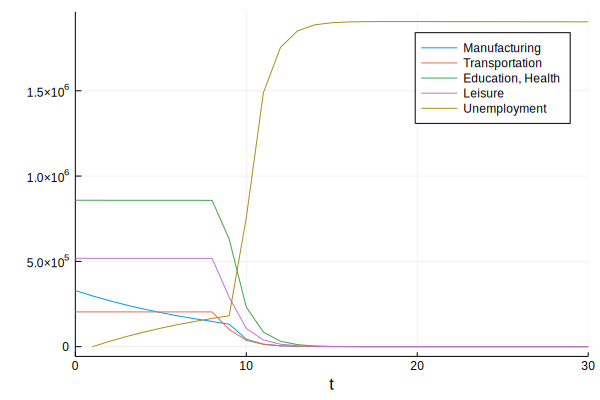

In [235]:
# sum total unemployment
# unemployment
uE = Float64[]
# unemployment rate
uEr = Float64[]

for i = 1:30
    total_uE = 0.0
    total_E = 0.0
    for j = 1:no_sectors
        total_uE = total_uE + sol1[j+no_sectors,i]
        total_E = total_E + sol1[j,i]
    end
    push!(uE,total_uE)
    push!(uEr,total_uE/total_E)
end

plot(sol1,vars=(1),label="Manufacturing")
plot!(sol1,vars=(2),label="Transportation")
plot!(sol1,vars=(3),label="Education, Health")
plot!(sol1,vars=(4),label="Leisure")
plot!(uE,label="Unemployment")

### Simulate Los Angeles
Here we take employment changes for the sectors from March to April 2020. The assumption here is that those losses reflect mostly the shutdown, and not economic losses cascading from the shutdown. The numbers are staggering.

In [240]:
# the initial values, or initial sector sizes
u0 = Float64[328900.00,203700.00,858300.00,517800.00,0.00,0.00,0.00,0.00]
# parameters for ODE system
p = Float64[0.003174603174603 0.002536409752905 0.003611790749155 0.012553109308613; 0.00008 0.00008 0.00008 0.00008; 0.00 0.00 0.00 0.00]

# set up the solver for the ODE (Ordinary Differential Equations)
tspan = (0.0,365.0)
prob2 = ODEProblem(sector1!,u0,tspan,p)
sol2 = solve(prob2,saveat=1.0);

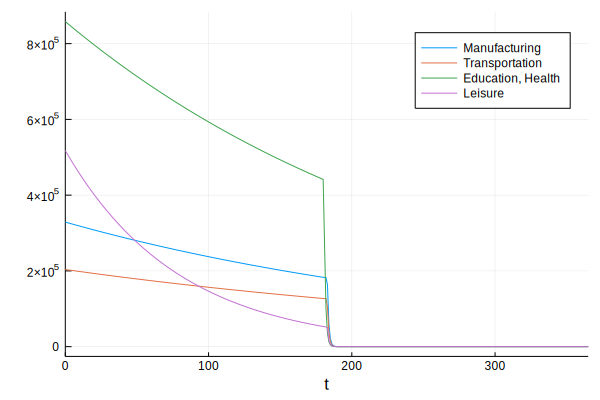

In [241]:
# sum total unemployment
# unemployment
uE = Float64[]
# unemployment rate
uEr = Float64[]

for i = 1:365
    total_uE = 0.0
    total_E = 0.0
    for j = 1:no_sectors
        total_uE = total_uE + sol2[j+no_sectors,i]
        total_E = total_E + sol2[j,i]
    end
    push!(uE,total_uE)
    push!(uEr,total_uE/total_E)
end

plot(sol2,vars=(1),label="Manufacturing")
plot!(sol2,vars=(2),label="Transportation")
plot!(sol2,vars=(3),label="Education, Health")
plot!(sol2,vars=(4),label="Leisure")
#plot!(uE,label="Unemployment")